# Мегалайн

В нашем распоряжении данные о пользователях тарифами `Smart` и `Ultra`, компании «Мегалайн» — федерального оператора сотовой связи, за 2018 год.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Нужно проверить 2 гипотезы:
* 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
* 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

## Обзор данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
from functools import reduce
idx = pd.IndexSlice
import matplotlib.pyplot as plt

try:
    df_calls = pd.read_csv('Desktop/files/stat_data/calls.csv')
    df_internet = pd.read_csv('Desktop/files/stat_data/internet.csv', index_col=0)
    df_messages = pd.read_csv('Desktop/files/stat_data/messages.csv')
    df_tariffs = pd.read_csv('Desktop/files/stat_data/tariffs.csv')
    df_users = pd.read_csv('Desktop/files/stat_data/users.csv')
except:
    df_calls = pd.read_csv('/datasets/calls.csv')
    df_internet = pd.read_csv('/datasets/internet.csv', index_col=0)
    df_messages = pd.read_csv('/datasets/messages.csv')
    df_tariffs = pd.read_csv('/datasets/tariffs.csv')
    df_users = pd.read_csv('/datasets/users.csv')

In [2]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [3]:
df_calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [4]:
df_calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

Таблица calls (информация о звонках):


* `id`        —  уникальный номер звонка
* `call_date` —  дата звонка, должно быть datatime по факту object
* `duration`  —  длительность звонка в минутах
* `user_id`   —  идентификатор пользователя, сделавшего звонок

В целом всё в норме, нужно только привести значения столбца даты звонка к соответствующему типу и время звонка привести к минутам и округлить в большую сторону (минуты представленны в виде десятичной дроби, легко исправить делением на 0.6). Пропусков нет.

In [5]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [6]:
df_internet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [7]:
df_internet.isna().sum()

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Таблица internet (информация об интернет-сессиях):


* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии, изменить тип данных
* `user_id` — идентификатор пользователя

Столбец `Unnamed: 0` в описании не числится, и дублирует индекс таблицы - будем удалять. Округлить значения столбца `mb_used` в большую сторону, и изменить тип данных в `session_date`. Пропусков нет.

In [8]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [9]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [10]:
df_messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

Таблица messages (информация о сообщениях):


* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

Пропусков нет, столбец с датой сообщения нужно привести к формату Datatime.

In [11]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [12]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица tariffs (информация о тарифах):


* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Ошибок нет.

In [13]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [14]:
df_users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [15]:
df_users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Таблица users (информация о пользователях):


* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

Пропуски в `churn_date` нужно заменить и привести к правильному типу, `reg_date` изменить тип данных.

В целом данных для работы достаточно. Ошибок мало и они не существенны. Можно продолжать работать.

## Предобработка данных

### Звонки

Изменим тип данных в столбце `df_calls['call_date']`.

In [16]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format = '%Y-%m-%d')

In [17]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Переведем минуты из десятичной дроби и округлим значение в большую стороную

In [18]:
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)

In [19]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


### Интернет

In [20]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format = '%Y-%m-%d') # приводим к нужному формату
df_internet['mb_used'] = np.ceil(df_internet['mb_used']).astype(int) # округляем в большую сторону

In [21]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  int64         
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.7+ MB


### Сообщения

In [22]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y-%m-%d') # приводим к нужному формату

In [23]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


### Пользователи

In [24]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format = '%Y-%m-%d') # приводим к нужному формату
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format = '%Y-%m-%d') # и тут приводим к нужному формату

In [25]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Звонки пользователей

#### Посчитаем для каждого пользователя количество сделанных звонков.

In [26]:
df_calls['month'] = df_calls['call_date'].dt.month # добавим столбец с месяцем звонка
df_users['user_index'] = df_users['city'] + df_users['first_name'] + df_users['last_name'] # добавим столбец с уникальным индексом пользователя

calls_data = df_calls.merge(df_users, on='user_id', how='inner')
sum_calls_month = calls_data.pivot_table(values=['user_index', 'duration'], 
                       index=['user_id', 'city', 'month'], 
                       aggfunc={'user_index': 'count', 'duration': 'sum'})

sum_calls_month.columns = ['duration', 'calls']

### Количество сообщений

#### Посчитаем количество отправленных сообщений по месяцам

In [27]:
df_messages['month'] = df_messages['message_date'].dt.month # добавим столбец с месяцем сообщения

messages_data = df_messages.merge(df_users, on='user_id', how='inner')
count_messages_month = messages_data.pivot_table(values='user_index', 
                       index=['user_id', 'city', 'month'],
                       aggfunc={'user_index': 'count'})

count_messages_month.columns = ['messages']

### Трафик интернета

#### Посчитаем объем израсходованного интернет-трафика по месяцам

In [28]:
df_internet['month'] = df_internet['session_date'].dt.month

internet_data = df_internet.merge(df_users, on='user_id', how='inner')
sum_internet_month = internet_data.pivot_table(values='mb_used', 
                       index=['user_id', 'city', 'month'], 
                       aggfunc={'mb_used': 'sum'})
sum_internet_month.columns = ['mb_used']

In [29]:
df_united = [sum_calls_month, count_messages_month, sum_internet_month]
data_united = reduce(lambda left,right: pd.merge(left,right,on=['user_id', 'city', 'month'], how='outer'), df_united)
data_united.head(10)

duration  calls  messages  mb_used
user_id city      month                                    
1000    Краснодар 5         159.0   22.0      22.0   2256.0
                  6         172.0   43.0      60.0  23257.0
                  7         340.0   47.0      75.0  14016.0
                  8         408.0   52.0      81.0  14070.0
                  9         466.0   58.0      57.0  14581.0
                  10        350.0   57.0      73.0  14717.0
                  11        338.0   43.0      58.0  14768.0
                  12        333.0   46.0      70.0   9827.0
1001    Москва    11        430.0   59.0       NaN  18452.0
                  12        414.0   63.0       NaN  14053.0

In [30]:
data_united.isna().sum()

duration     40
calls        40
messages    497
mb_used      11
dtype: int64

В таблице получилось много пропусков и значения не целочисленные. Заменим пропуски на 0, а тип данных изменим на целочисленный.

In [31]:
data_united['duration'] = data_united['duration'].fillna(0).astype(int)
data_united['calls'] = data_united['calls'].fillna(0).astype(int)
data_united['messages'] = data_united['messages'].fillna(0).astype(int)
data_united['mb_used'] = data_united['mb_used'].fillna(0).astype(int)

In [32]:
for df_user in data_united.index:
    data_united.loc[df_user, 'tariff'] = df_users.loc[df_user[0]-1000, 'tariff'];

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [33]:
data_united.head(10)

duration  calls  messages  mb_used tariff
user_id city      month                                           
1000    Краснодар 5           159     22        22     2256  ultra
                  6           172     43        60    23257  ultra
                  7           340     47        75    14016  ultra
                  8           408     52        81    14070  ultra
                  9           466     58        57    14581  ultra
                  10          350     57        73    14717  ultra
                  11          338     43        58    14768  ultra
                  12          333     46        70     9827  ultra
1001    Москва    11          430     59         0    18452  smart
                  12          414     63         0    14053  smart

### Выручка

#### Посчитаем помесячную выручку 

Создадим функцию которая берет на вход данные из  `revenue`  и возвращает выручку для конкретного пользователя в конкретный месяц.

In [34]:
def income_counter(row):
    duration = row['duration']
    calls = row['calls']
    messages = row['messages']
    mb_used = row['mb_used']
    tariff = row['tariff']
    
    if tariff == 'smart':
        over_limit_duration = duration - df_tariffs.loc[0, 'minutes_included']
        over_limit_mb = mb_used - df_tariffs.loc[0, 'mb_per_month_included']
        over_limit_messages = messages - df_tariffs.loc[0, 'messages_included']
        
        if over_limit_duration < 0: over_limit_duration = 0
        if over_limit_mb < 0: over_limit_mb = 0
        if over_limit_messages < 0: over_limit_messages = 0
        
        return (df_tariffs.loc[0, 'rub_per_message'] * over_limit_messages + 
                   (df_tariffs.loc[0, 'rub_per_gb'] / 1024) * over_limit_mb + 
                   df_tariffs.loc[0, 'rub_per_minute'] * over_limit_duration + 
                   df_tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        over_limit_duration = duration - df_tariffs.loc[1, 'minutes_included']
        over_limit_mb = mb_used - df_tariffs.loc[1, 'mb_per_month_included']
        over_limit_messages = messages - df_tariffs.loc[1, 'messages_included']
        
        if over_limit_duration < 0: over_limit_duration = 0
        if over_limit_mb < 0: over_limit_mb = 0
        if over_limit_messages < 0: over_limit_messages = 0
        
        return (df_tariffs.loc[1, 'rub_per_message'] * over_limit_messages + 
                   (df_tariffs.loc[1, 'rub_per_gb'] / 1024) * over_limit_mb + 
                   df_tariffs.loc[1, 'rub_per_minute'] * over_limit_duration + 
                   df_tariffs.loc[1, 'rub_monthly_fee']
                  )

In [35]:
data_united['revenue'] = data_united.apply(income_counter, axis=1).astype(int)
data_united.head(10)

duration  calls  messages  mb_used tariff  revenue
user_id city      month                                                    
1000    Краснодар 5           159     22        22     2256  ultra     1950
                  6           172     43        60    23257  ultra     1950
                  7           340     47        75    14016  ultra     1950
                  8           408     52        81    14070  ultra     1950
                  9           466     58        57    14581  ultra     1950
                  10          350     57        73    14717  ultra     1950
                  11          338     43        58    14768  ultra     1950
                  12          333     46        70     9827  ultra     1950
1001    Москва    11          430     59         0    18452  smart     1153
                  12          414     63         0    14053  smart      550

## Анализ данных

### Тариф *Smart*

#### Распределение звонков в тарифе *Smart*

In [36]:
smart_table = data_united[data_united['tariff'] == 'smart'].replace(0, np.NaN)

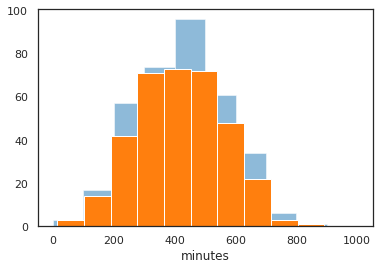

Среднее: 420.8480194908561
Дисперсия: 20578.276241342694
Стандартное отклонение: 143.4513026826271


In [37]:
calls_smart = smart_table.pivot_table(index='user_id', values='duration')

for column in calls_smart.columns.values.tolist():
    plt.hist(calls_smart[column], range=(1,1000), alpha=0.5)
calls_smart['mean_value'] = calls_smart.apply(pd.DataFrame.mean, axis=1) 
plt.hist(calls_smart['mean_value'])
plt.xlabel('minutes')
plt.show()
print('Среднее:', calls_smart['mean_value'].mean())
print('Дисперсия:', calls_smart['mean_value'].var())
print('Стандартное отклонение:', calls_smart['mean_value'].std())

#### Распределение сообщений в тарифе *Smart*

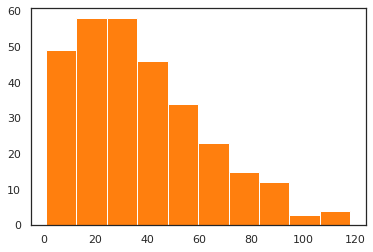

Среднее: 37.57560563057251
Дисперсия: 617.5094965861842
Стандартное отклонение: 24.849738360517687


In [38]:
messages_smart = smart_table.pivot_table(index='user_id', values='messages')

for column in messages_smart.columns.values.tolist():
    plt.hist(messages_smart[column], alpha=0.5)
messages_smart['mean_value'] = messages_smart.apply(pd.DataFrame.mean, axis=1)
plt.hist(messages_smart['mean_value'])
plt.show()
messages_smart['mean_value'].describe()
print('Среднее:', messages_smart['mean_value'].mean())
print('Дисперсия:', messages_smart['mean_value'].var())
print('Стандартное отклонение:', messages_smart['mean_value'].std())

#### Распределение трафика в тарифе *Smart*

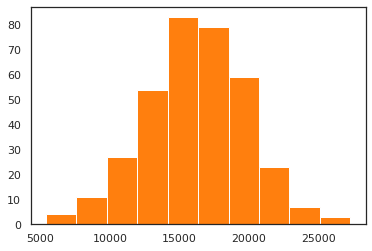

Среднее: 15.85644825678259
Дисперсия: 13156112.194393754
Стандартное отклонение: 3.542124546589574


In [39]:
internet_smart = smart_table.pivot_table(index='user_id', values='mb_used')

for column in internet_smart.columns.values.tolist():
    plt.hist(internet_smart[column], alpha=0.5)
internet_smart['mean_value'] = internet_smart.apply(pd.DataFrame.mean, axis=1)
plt.hist(internet_smart['mean_value'])
plt.show()
print('Среднее:', internet_smart['mean_value'].mean() / 1024)
print('Дисперсия:', internet_smart['mean_value'].var())
print('Стандартное отклонение:', internet_smart['mean_value'].std() / 1024)

#### Вывод

* В среднем пользователи тарифа `Smart` используют 421 минуту, что укладывается в пакет минут включенных в тариф. Стандартное отклонение 143 минуты. Распределение нормальное.
* Из доступных 50 СМС в среднем используются лишь 38 сообщений и это не удивительно при современном развитии мессенджеров. Стандартное отклонение 25. Распределение скошено в право.
* 15.85Гб. столько трафика в среднем расходует в месяц пользователь тарифа `Smart`. Стандартное откланение 3.54Гб.. Нормальное распределение.

### Тариф *Ultra*

#### Распределение звонков в тарифе *Ultra*

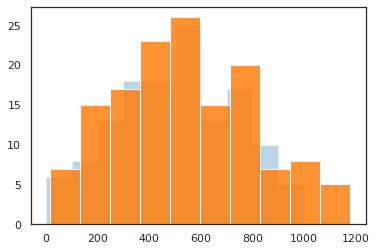

Среднее: 546.9984013461286
Дисперсия: 71872.0671269184
Стандартное отклонение: 268.08966247678853


In [40]:
ultra_table = data_united[data_united['tariff'] == 'ultra'].replace(0, np.NaN)

calls_ultra = ultra_table.pivot_table(index='user_id', values='duration')

for column in calls_ultra.columns.values.tolist():
    plt.hist(calls_ultra[column], range=(1,1000), alpha=0.3)
calls_ultra['mean_value'] = calls_ultra.apply(pd.DataFrame.mean, axis=1)
plt.hist(calls_ultra['mean_value'], alpha=0.85)
plt.show()
print('Среднее:', calls_ultra['mean_value'].mean())
print('Дисперсия:', calls_ultra['mean_value'].var())
print('Стандартное отклонение:', calls_ultra['mean_value'].std())

#### Распределение сообщений в тарифе *Ultra*

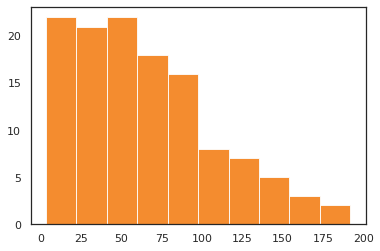

Среднее: 64.55580197132616
Дисперсия: 1882.7452175564708
Стандартное отклонение: 43.390612090133864


In [41]:
messages_ultra = ultra_table.pivot_table(index='user_id', values='messages')

for column in messages_ultra.columns.values.tolist():
    plt.hist(messages_ultra[column], alpha=0.3)
messages_ultra['mean_value'] = messages_ultra.apply(pd.DataFrame.mean, axis=1)
plt.hist(messages_ultra['mean_value'], alpha=0.85)
plt.show()
print('Среднее:', messages_ultra['mean_value'].mean())
print('Дисперсия:', messages_ultra['mean_value'].var())
print('Стандартное отклонение:', messages_ultra['mean_value'].std())

#### Распределение трафика в тарифе *Ultra*

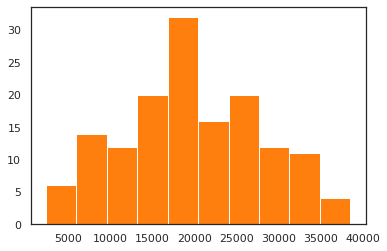

Среднее: 19.299253517709055
Дисперсия: 66869619.030235656
Стандартное отклонение: 7.9857271564339305


In [42]:
internet_ultra = ultra_table.pivot_table(index='user_id', values='mb_used')

for column in internet_ultra.columns.values.tolist():
    plt.hist(internet_ultra[column], alpha=0.3)
internet_ultra['mean_value'] = internet_ultra.apply(pd.DataFrame.mean, axis=1)
plt.hist(internet_ultra['mean_value'])
plt.show()
print('Среднее:', internet_ultra['mean_value'].mean() / 1024)
print('Дисперсия:', internet_ultra['mean_value'].var())
print('Стандартное отклонение:', internet_ultra['mean_value'].std() / 1024)

#### Вывод

* Не смотря на то что в тариф `Ultra` включает в стандартный пакет 3000 минут, среднестатистический пользователь тратит около 550 минут. Стандартное отклонение 268. Нормальное распределение.
* Болшенству пользователей не пригодился пакет с 1000 СМС в среднем хватает и 65. Стандартное отклонение 43.
* В среднем 20Гб. из 30 тратят пользователи тарифа `Ultra`. Стандартное откланение 8гб.. Распределение нормальное.

####  Для сравнение посмотрим на общее распределение звонков, сообщений и интернет трафика.

Среднее: 456.9316320100819
Дисперсия: 56658.88564895877
Стандартное отклонение: 238.03127031749162


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


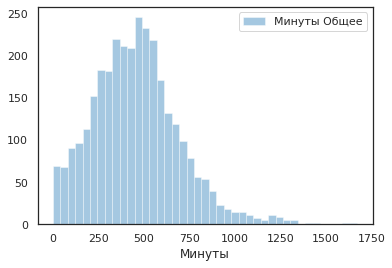

In [43]:
for minutes in ['duration']:
    sns.distplot(sum_calls_month['duration'], kde=False, label=minutes, axlabel='Минуты');
plt.legend(['Минуты Общее']);
print('Среднее:', sum_calls_month['duration'].mean())
print('Дисперсия:', sum_calls_month['duration'].var())
print('Стандартное отклонение:', sum_calls_month['duration'].std())

Среднее: 45.28376886271623
Дисперсия: 1228.5980170128298
Стандартное отклонение: 35.051362555724275


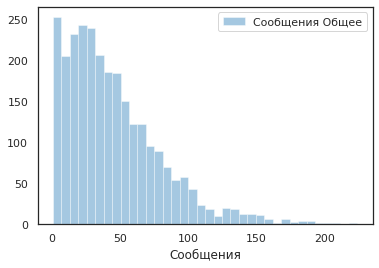

In [44]:
for messages in ['messages']:
    sns.distplot(count_messages_month['messages'], kde=False, label=messages, axlabel='Сообщения');
plt.legend(['Сообщения Общее']);
print('Среднее:', count_messages_month['messages'].mean())
print('Дисперсия:', count_messages_month['messages'].var())
print('Стандартное отклонение:', count_messages_month['messages'].std())

Среднее: 16.881591415762568
Дисперсия: 56604261.01411212
Стандартное отклонение: 7.347246418102113


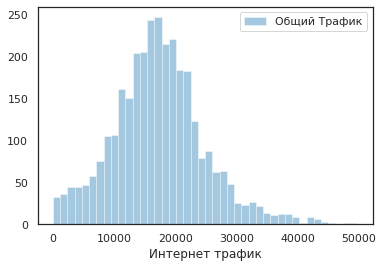

In [45]:
for internet in ['mb_used']:
    sns.distplot(sum_internet_month['mb_used'], kde=False, label=internet, axlabel='Интернет трафик');
plt.legend(['Общий Трафик']);
print('Среднее:', sum_internet_month['mb_used'].mean() / 1024)
print('Дисперсия:', sum_internet_month['mb_used'].var())
print('Стандартное отклонение:', sum_internet_month['mb_used'].std() / 1024)

 Для наглядности наложим распределения по тарифам друг на друга:

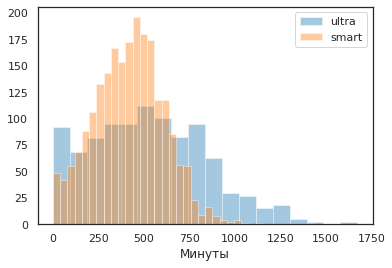

In [46]:
for tariff in ['ultra', 'smart']:
    sns.distplot(data_united.query('tariff == @tariff')['duration'], kde=False, label=tariff, axlabel='Минуты');
plt.legend(['ultra', 'smart']);

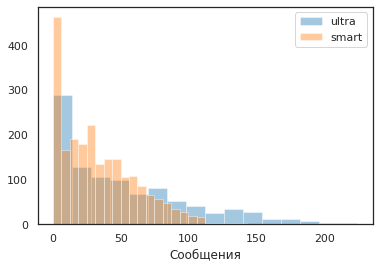

In [47]:
for tariff in ['ultra', 'smart']:
    sns.distplot(data_united.query('tariff == @tariff')['messages'], kde=False, label=tariff, axlabel='Сообщения');
plt.legend(['ultra', 'smart']);

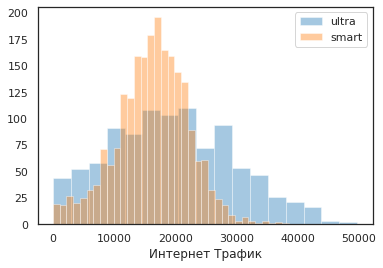

In [48]:
for tariff in ['ultra', 'smart']:
    sns.distplot(data_united.query('tariff == @tariff')['mb_used'], kde=False, label=tariff, axlabel='Интернет Трафик', ax=None)
plt.legend(['ultra', 'smart']);

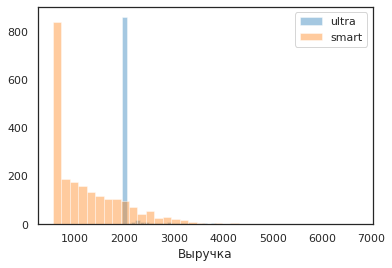

In [49]:
for tariff in ['ultra', 'smart']:
    sns.distplot(data_united.query('tariff == @tariff')['revenue'], kde=False, label=tariff, axlabel='Выручка');
plt.legend(['ultra', 'smart']);

Вот тут становится интересно два пика 550 и 1950, как и ожидалось, но вот от пика 550 идет длинный хвост в сторону увеличения расходов, чего не наблюдается для клиентов тарифа `Ultra`. Обратимся к методу `describe`:

In [50]:
data_united.describe()

,duration,calls,messages,mb_used,revenue
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,451.244866,63.038892,38.281269,17227.585252,1486.634101
std,241.909978,33.236368,36.148326,7578.261501,783.896681
min,0.000000,0.000000,0.000000,0.000000,550.000000
25%,282.000000,40.000000,9.000000,12505.250000,694.000000
50%,443.000000,62.000000,30.000000,16966.500000,1562.500000
75%,589.000000,82.000000,57.000000,21450.000000,1950.000000
max,1673.000000,244.000000,224.000000,49789.000000,6711.000000


На обьединеной таблице ни чего не видно. Посмотрим на каждый тариф по отдельности.

In [51]:
smart_table.describe()

,duration,calls,messages,mb_used,revenue
count,2221.000000,2223.000000,1922.000000,2227.000000,2229.000000
mean,419.440342,58.621233,38.716441,16243.763359,1233.057873
std,188.992403,25.796101,26.787949,5860.041941,787.544032
min,2.000000,1.000000,1.000000,202.000000,550.000000
25%,285.000000,40.000000,17.000000,12677.000000,550.000000
50%,423.000000,60.000000,34.000000,16533.000000,959.000000
75%,546.000000,76.000000,55.000000,20068.000000,1668.000000
max,1435.000000,198.000000,143.000000,38610.000000,6711.000000


И что мы видим:

* Лишь 25% пользователей тарифа `Smart` укладываются в абанентскую плату согластно тарифа. 
* почти половина переплачивает вдвое, а четверть втрое! 
* 75% пользователей тарифа `Smart` расходуют интернет трафик сверх пакета.
* И только 25% не хватает минут заложенных в стандартный пакет.
* СМС хватает 75% клиентов.

In [52]:
ultra_table.describe()

,duration,calls,messages,mb_used,revenue
count,947.000000,951.000000,795.000000,974.000000,985.000000
mean,547.755016,76.016824,61.161006,19706.979466,2060.462944
std,305.513385,42.403348,45.931026,9937.127298,356.187378
min,1.000000,1.000000,1.000000,366.000000,1950.000000
25%,311.000000,43.000000,24.000000,12073.750000,1950.000000
50%,529.000000,75.000000,51.000000,19427.500000,1950.000000
75%,758.000000,105.000000,87.500000,26936.250000,1950.000000
max,1673.000000,244.000000,224.000000,49789.000000,4743.000000


In [53]:
print('Процент клиентов переплачивающих по тарифу Ultra - {:.2%}'.format(
    ultra_table[ultra_table['revenue'] > 1950].shape[0]/ultra_table.shape[0]))

Процент клиентов переплачивающих по тарифу Ultra - 13.60%


Пользователи тарифа `Ultra` не привыкли переплачивать, и лишь единицам не хватает стандартных пакетов, включенных в абонентскую плату.

## Проверка гипотиз

#### Гипотеза №1:
Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Исходя из формулировки гипотезы мы можем выдвинуть Ho как «Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются.», а H1 как «Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.».

In [54]:
ultra = data_united.query('tariff == "ultra"')['revenue']
smart = data_united.query('tariff == "smart"')['revenue']


alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(ultra, smart, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.133013116078655e-296
Отвергаем нулевую гипотезу


#### Гипотеза №2:
Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

За Ho примем «Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.», за H1  примем «Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.».

In [55]:
for user in data_united.index:
    data_united.loc[user, 'city'] = df_users.loc[user[0]-1000, 'city']

moscow = data_united.query('city == "Москва"')['revenue']
regions = data_united.query('city != "Москва"')['revenue']

alpha = 0.05 # критический уровень статистической значимости


results = st.ttest_ind(moscow, regions, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


p-значение: 0.4546446281204245
Не получилось отвергнуть нулевую гипотезу


#### Вывод

* Гипотеза о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются верна.
* Гипотеза о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов не верна.

## Общий вывод

Подводя итог проделанной работы можно сделать следующие выводы:

Тариф `Smart`:

* Лишь 25% пользователей тарифа `Smart` укладываются в абанентскую плату согластно тарифа.
* 75% пользователей тарифа `Smart` расходуют интернет трафик сверх пакета, 15.85Гб. столько трафика в среднем расходует в месяц пользователь тарифа `Smart`.
* В среднем пользователи тарифа `Smart` используют 421 минуту, что укладывается в пакет минут включенных в тариф, однако почти трети клиентов лимита заложенного в пакет не хватает. 
* Из доступных 50 СМС в среднем используются лишь 38 сообщений, прогресс не стоит на месте и СМС становятся рудементом нежели удобным средством общения. 

Тариф `Ultra`:

* Не смотря на то что в тариф `Ultra` включает в стандартный пакет 3000 минут, среднестатистический пользователь тратит около 550 минут.
* Болшенству пользователей не пригодился пакет с 1000 СМС в среднем хватает и 65.
* В среднем 20Гб. из 30 тратят пользователи тарифа `Ultra`.

С точки зрения поведения клиентов более удобным является тариф `Smart`, так как даже с учетом того что многие выходят за рамки входящих в тариф пакетов минут, СМС и интернет трафика, тариф `Smart`, в среднем обходится на 717 рублей дешевле тарифа `Ultra`, хотя изначально почти в 3 раза дешевле.

Если смотреть на картину с точки зрения компании "МегаЛайн", то тариф `Ultra` является более предпочтительным для дальнешего продвижения, ведь даже самые экономичные клиенты (те что не выходят за рамки стандартных пакетов) приносят дахода больше чем большинство клиентов тарифа `Smart` превышающих лимит стандартного пакета.

Удалось проверить 2 гипотезы:


Гипотеза №1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. - подтвердилась.

Гипотеза №2: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. - не подтвердилась. 